In [2]:
import io
#import os, sys
import requests
import PIL
from pathlib import Path

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 128
#target_image_size = 256
#target_image_size = 512

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [3]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

In [4]:
#%wget https://nextcloud.colony47.de/nextcloud/s/iNMLktDC852yLgj/download/decoder.pkl

In [5]:
#%wget https://nextcloud.colony47.de/nextcloud/s/74z56WxmLEF52s3/download/encoder.pkl

In [8]:
%curl https://www.mein-schoener-garten.de/sites/default/files/styles/achor_navigation_l/public/venusfliegenfalle-dionaea-01039827-florapress.jpg?h=08b866d1&itok=XrkDJEQS -o dionaea.jpg

UsageError: Line magic function `%curl` not found.


UsageError: UsageError: Line magic function `%curl` not found.

In [7]:
%ls

Asimov.jpg       init.sh                              lost+found/
decoder.pkl      init.sh-2021-10-18-18-05-19.err.log  mathe.jpg
dog.jpg          init.sh-2021-10-18-19-49-13.err.log  ML.jpg
encoder.pkl      init.sh-2021-10-18-20-01-42.err.log
environment.yml  init.sh-2021-10-19-05-53-18.err.log


In [21]:
# For faster load times, download these files locally and use the local paths instead.
enc = load_model("./encoder.pkl", dev)
dec = load_model("./decoder.pkl", dev)

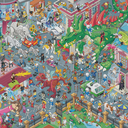

In [22]:
## Penguin
x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))

## Elephant
#x = preprocess(PIL.Image.open('./dog.png'))

# Wimmelbild
#x = preprocess(download_image('https://company.playmobil.com/sites/default/files/inline-images/Hoppenbrock_Drache_2017-final-RGB_klein.jpg'))

## Dog
#x = preprocess(PIL.Image.open('./dog.jpg'))

## Asimov
#x = preprocess(PIL.Image.open('./Asimov.jpg'))

display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

In [23]:
y_logits = enc(x)
y = torch.argmax(y_logits, axis=1)
y = F.one_hot(y, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

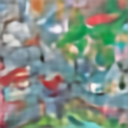

In [24]:
x_stats = dec(y).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)